<a href="https://colab.research.google.com/github/wahid028/Cryptocurrency-Price-Prediction/blob/master/g_research_crypto_forecasting_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#install kaggle
!pip install -q kaggle

In [21]:
#upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"learn2know","key":"ef7c1f3683ce0590f0cee38b88d74d21"}'}

In [23]:
#create a kaggle directory
!mkdir ~/.kaggledataset

In [24]:
#copy the kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggledataset/

In [25]:
#permission for the json to act
!chmod 600 ~/.kaggledataset/kaggle.json

In [26]:
#list all the available dataset in kaggle
!kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36           1095        743  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1199        686  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           4245        105  1.0              


In [28]:
!kaggle competitions download -c g-research-crypto-forecasting

 99% 1.13G/1.13G [00:18<00:00, 92.4MB/s]
100% 1.13G/1.13G [00:18<00:00, 65.2MB/s]


In [29]:
!unzip g-research-crypto-forecasting.zip

Archive:  g-research-crypto-forecasting.zip
  inflating: asset_details.csv       
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: gresearch_crypto/__init__.py  
  inflating: gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: supplemental_train.csv  
  inflating: train.csv               


In [31]:
!pip install datatable

     |████████████████████████████████| 96.9 MB 109 kB/s 


In [32]:
#download the standard libraries
import datetime
import numpy as np
import pandas as pd
import datatable as dt
pd.set_option("display.max_columns", None, "display.max_rows", None)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [34]:
%%time
train = dt.fread('../content/train.csv').to_pandas()

CPU times: user 16.9 s, sys: 3.19 s, total: 20.1 s
Wall time: 12.2 s


In [35]:
train = train.set_index('timestamp')
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [36]:
for i in range(14):
    print(i, len(train[train.Asset_ID == i])%60)

0 59
1 42
2 57
3 27
4 6
5 40
6 20
7 47
8 31
9 30
10 57
11 21
12 49
13 40


In [37]:
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    # fill null values with zeros for visualization
    df = df.fillna(0).fillna(0)
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()

In [38]:
# ensure dataframe is well padded
for i in range(14):
    print(i, len(train[train.Asset_ID == i])%60)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0


In [39]:
# ensure there is no null values in the dataframe
train.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [40]:
train = train.reset_index()
# sort dataframe by timestamp then by asset id for consistency
train = train.sort_values(by=['timestamp', 'Asset_ID'])
# convert date to datetime to enable extracting more useful info
train['date'] = pd.to_datetime(train.timestamp, unit='s')
train.drop(['timestamp'], axis=1, inplace=True)

In [41]:
# extract useful features from the datetime feature
train['min_'] = pd.DatetimeIndex(train['date']).minute.astype('uint8')
train['hr_'] = pd.DatetimeIndex(train['date']).hour.astype('uint8')
train['day_'] = pd.DatetimeIndex(train['date']).day.astype('uint8')
train['day_in_week'] = pd.DatetimeIndex(train['date']).day_of_week.astype('uint8')
train['week'] = pd.DatetimeIndex(train['date']).week.astype('uint8')
train['month'] = pd.DatetimeIndex(train['date']).month.astype('uint8')
train['is_month_start'] = pd.DatetimeIndex(train['date']).is_month_start.astype(int).astype('uint8')
train['is_month_end'] = pd.DatetimeIndex(train['date']).is_month_end.astype(int).astype('uint8')
train['is_quarter_start'] = pd.DatetimeIndex(train['date']).is_quarter_start.astype(int).astype('uint8')
train['is_quarter_end'] = pd.DatetimeIndex(train['date']).is_quarter_end.astype(int).astype('uint8')
train['is_year_start'] = pd.DatetimeIndex(train['date']).is_year_start.astype(int).astype('uint8')
train['is_year_end'] = pd.DatetimeIndex(train['date']).is_year_end.astype(int).astype('uint8')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [42]:
# convert float columns to float64 to reduce memory usage
float_cols = []
for col in train.columns.tolist():
    if train[col].dtypes == 'float64':
        float_cols.append(col)
    
train[float_cols] = train[float_cols].astype('float16')

# **EDA: Exploratory Data Analysis**

In this seection we will display only the data of Bitcoin(Asset_ID = 1) for the sake of simplicity. You can also explore other assets.

In [43]:
# select only date from 2021 for computational simplicity
df = train[train['date'] >= datetime.datetime(2021, 1, 1)].set_index('date', drop=True)
print(df.shape)

(5302094, 21)


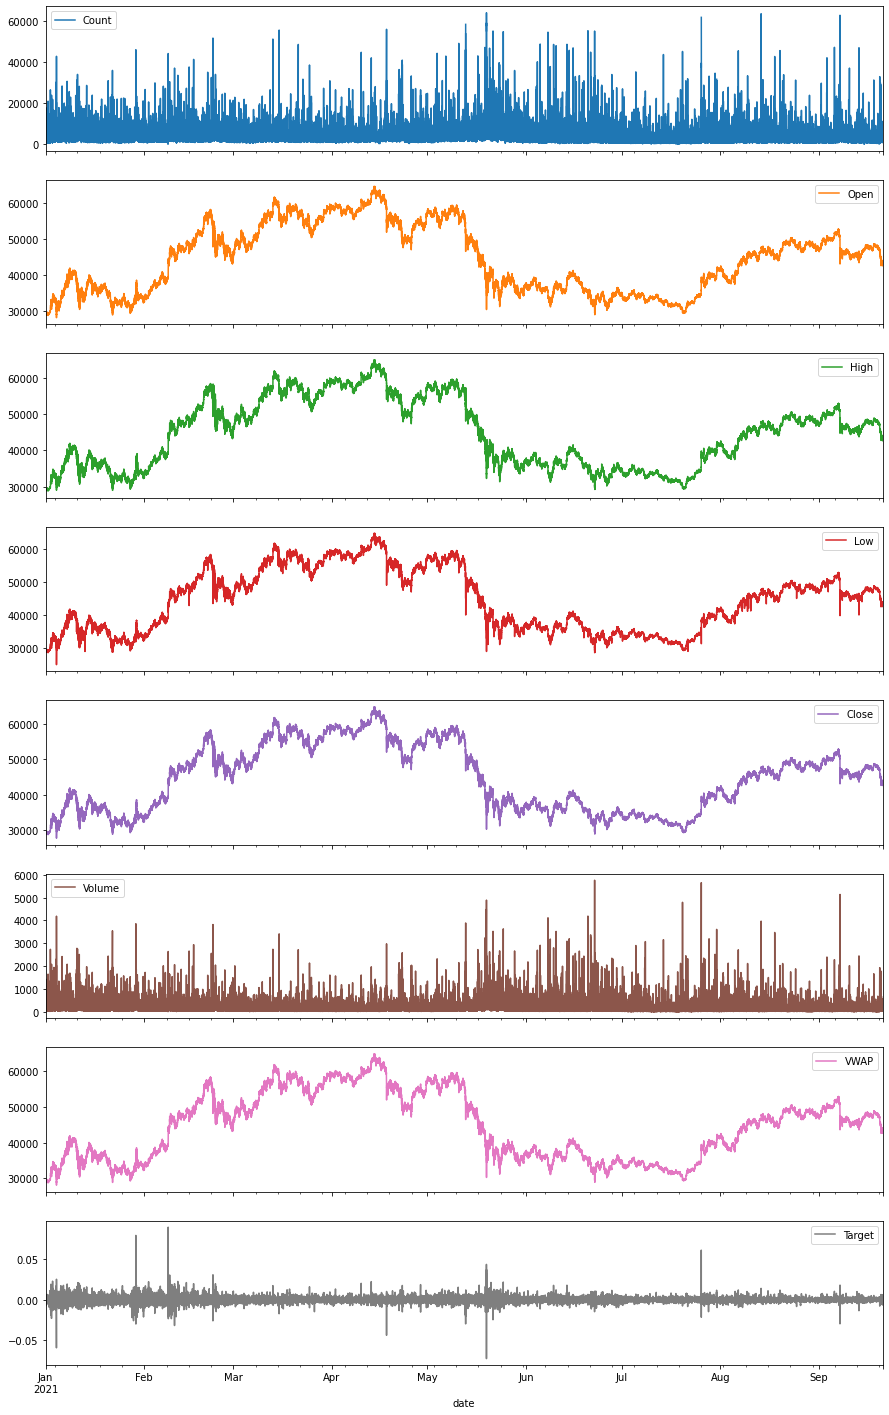

In [44]:
# from the line plot we can extract info on trends and seasonality
df[df['Asset_ID'] == 1][['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].plot(subplots=True, figsize=(15, 25))
plt.show()

We can see how the Target and the features are extremely noisy and hence we will try to smoothen these curves using some techniques. This might enable us to extract valuable information from our data

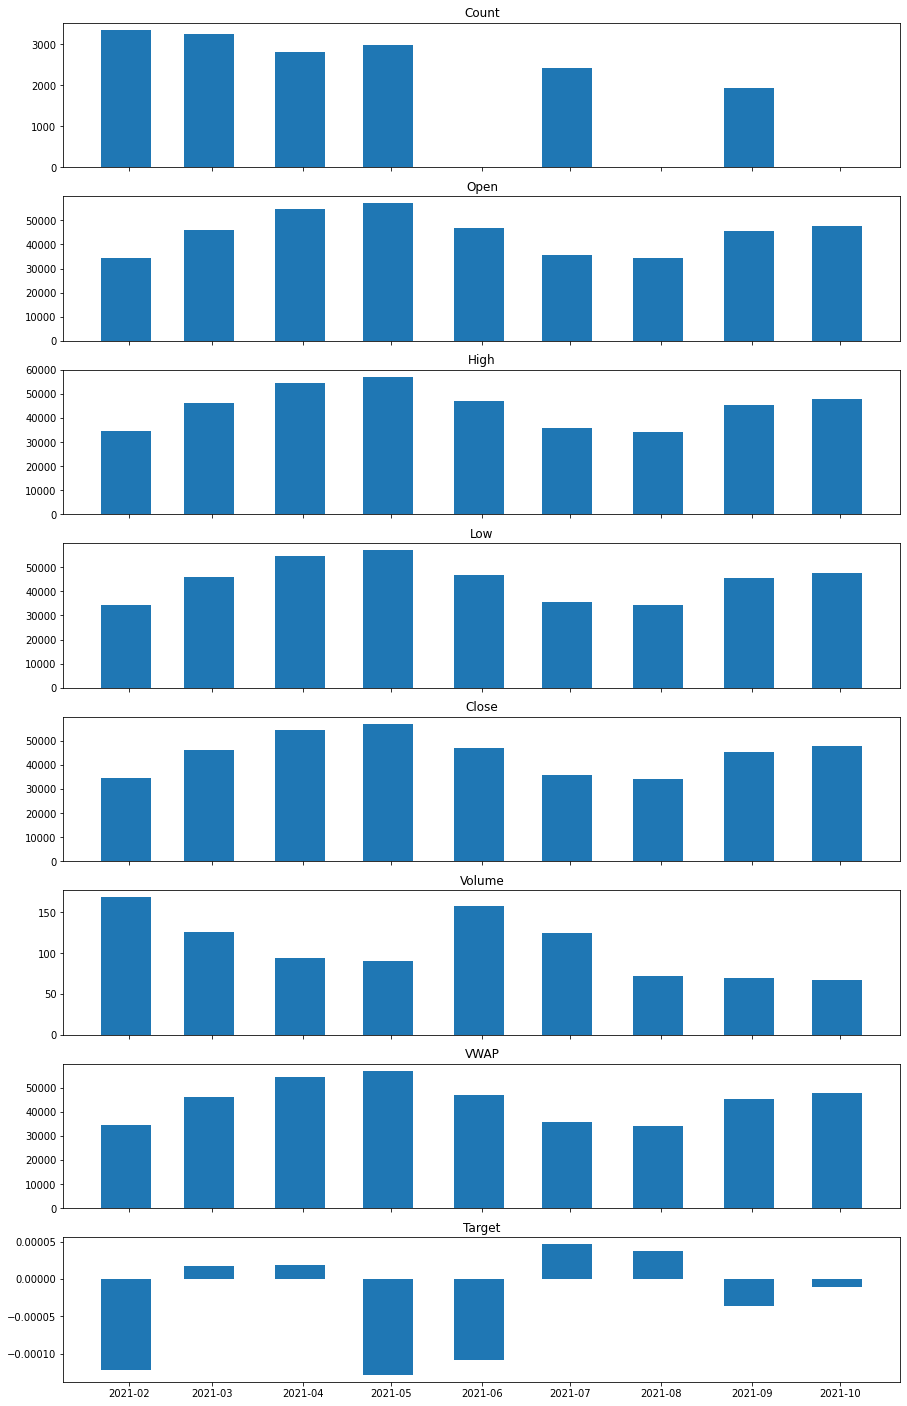

In [45]:
# first method to smoothen the curves is by resampling (aggregating) data over a wider period of time and taking the mean of these values
df_month = df[df['Asset_ID'] == 1].resample("M").mean()

fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
for name, ax in zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.bar(df_month.index, df_month[name], width=17, align='center')
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

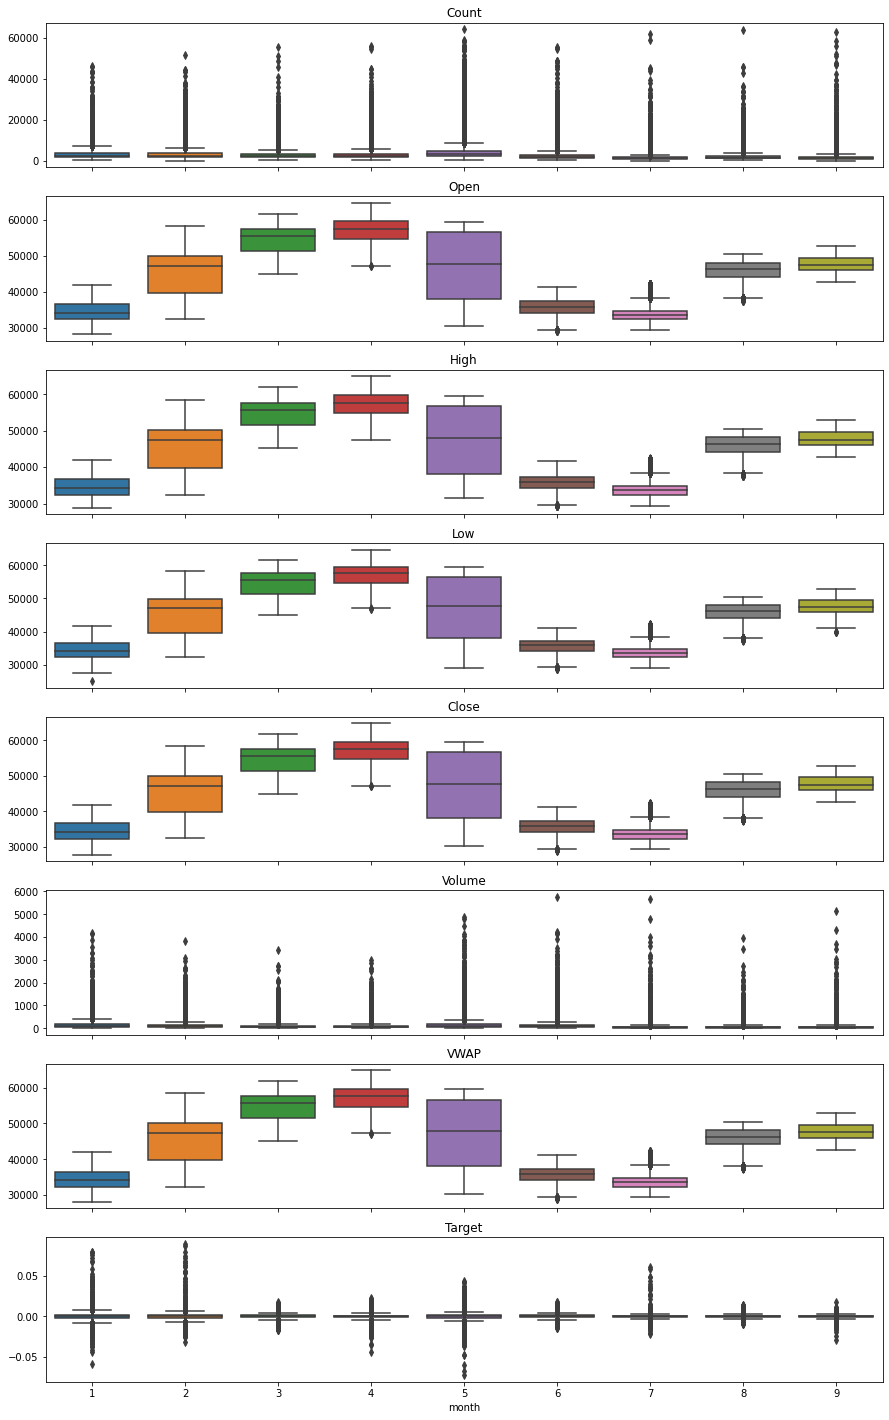

In [46]:
# boxplots provides us with more precious information where some important stats as median, interquartile range, outliers can be explored
fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
for name, ax in zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes):
    sns.boxplot(data = df[df['Asset_ID'] == 1], x='month', y=name, ax=ax)
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')
plt.savefig("fig_4.png")

In [47]:
# again we perform resampling and rolling, but this time on a daily basis which might provide more specific info
df_day = df[df['Asset_ID'] == 1].resample("D").mean()
df_day = df_day.fillna(0)

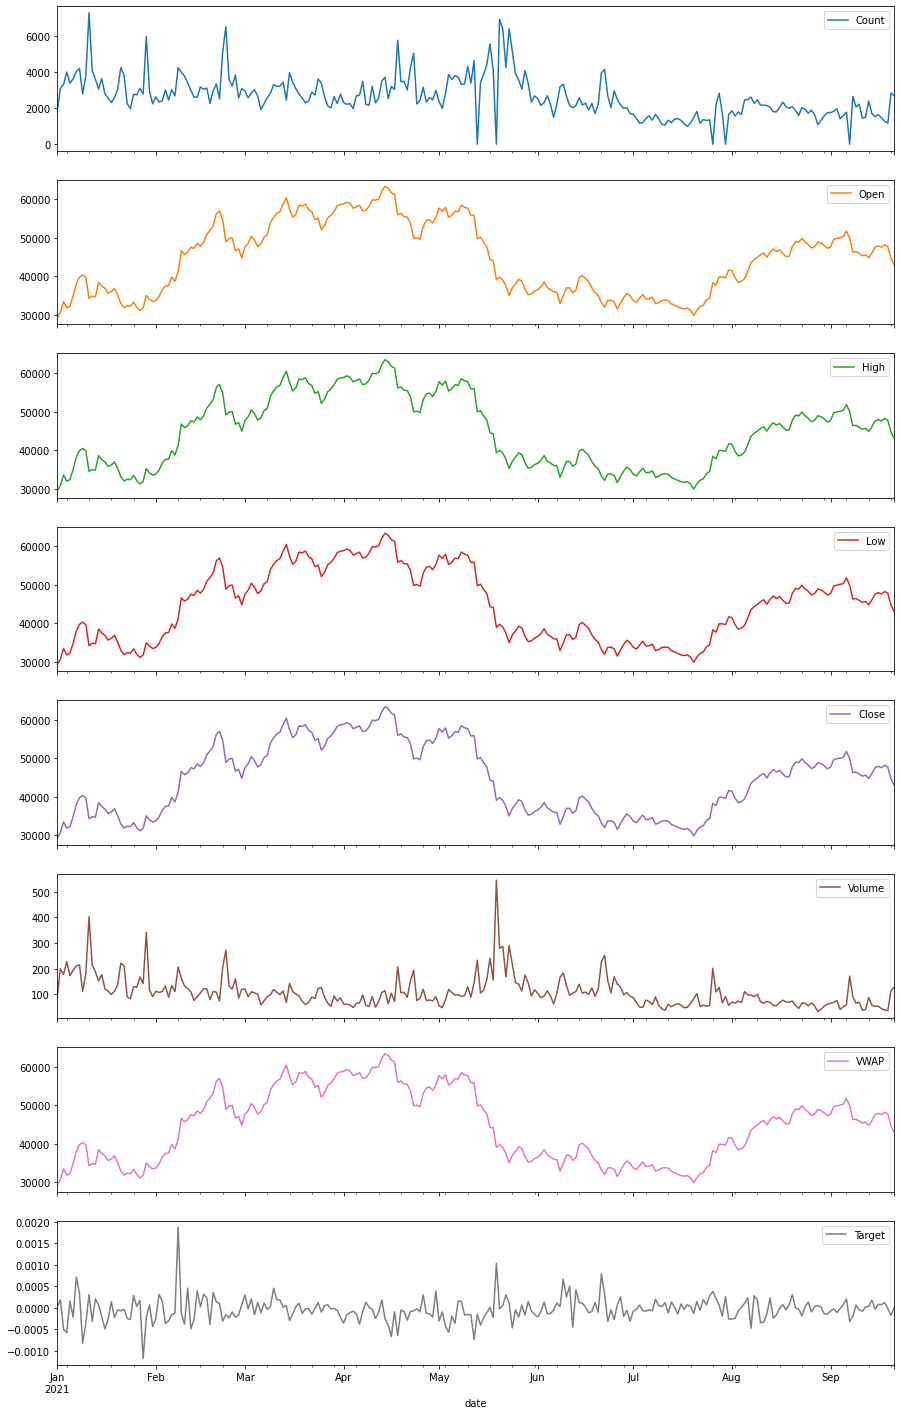

In [48]:
# from the line plot we can extract info on daily trends and seasonality
df_day[df_day['Asset_ID'] == 1][['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].plot(subplots=True, figsize=(15, 25))
plt.show()

In [49]:
# we still see a lot of spikes which are not helpful for modelling
# let's smooth them down by resampling to a lower freq and rolling
df_week = df[df['Asset_ID'] == 1].resample("W").mean()

In [50]:
df_week = df_week.astype('float64')
df_week = df_week.fillna(method='pad')

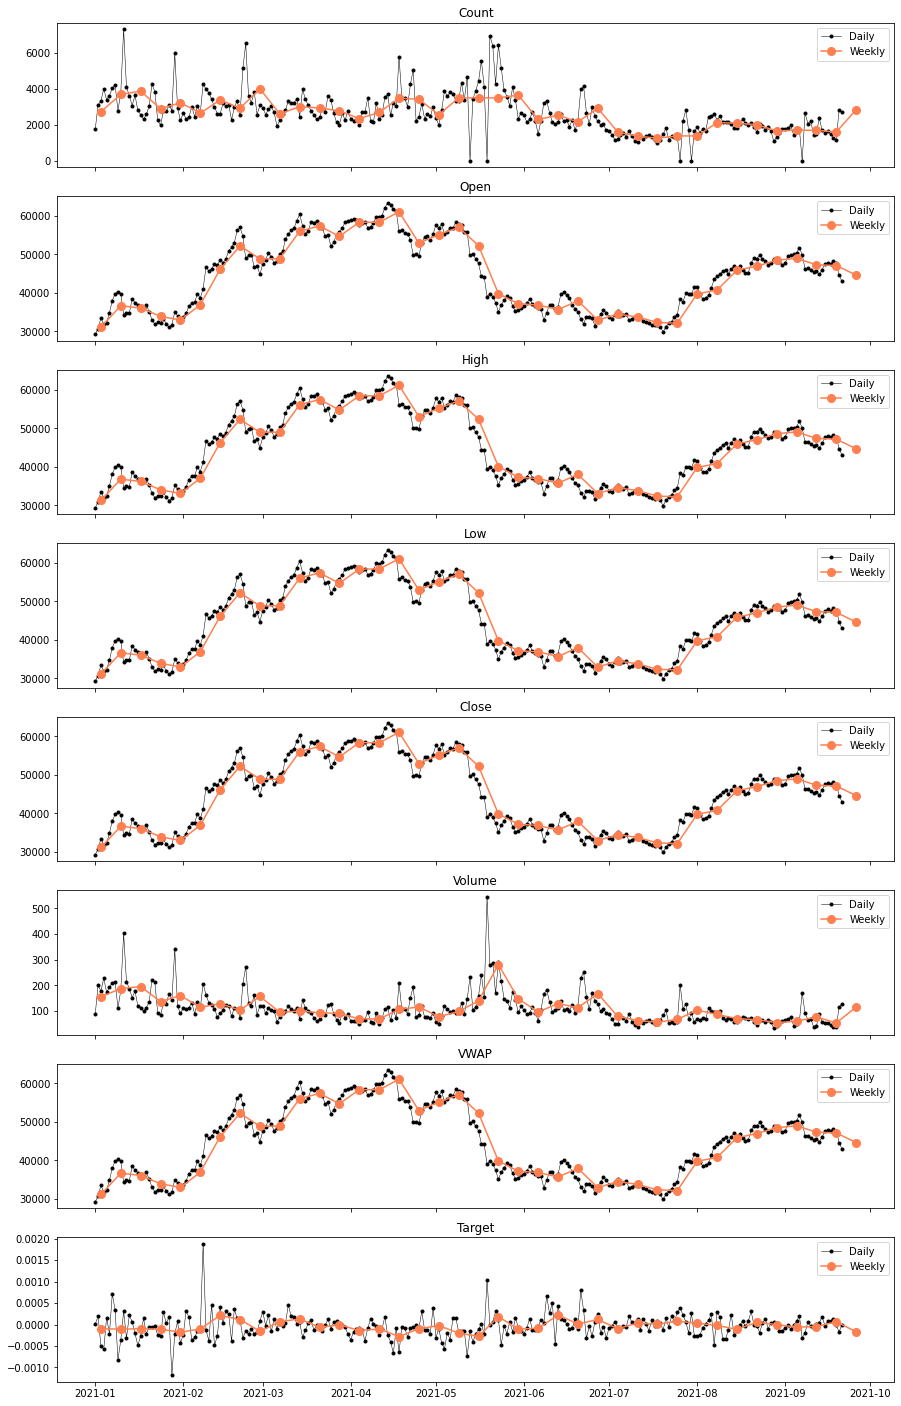

In [51]:
# here we compare the daily trends and seasonality to the weekly ones
fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=True)
for name, ax in zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes):
    ax.plot(df_day[name], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
    ax.plot(df_week[name], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
    ax.set_ylabel(name)
    ax.legend()
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

In [52]:
cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']
for col in cols:
    df_week[f'{col}_Change'] = df_week[col].div(df_week[col].shift())
    
df_week = df_week.fillna(method='bfill')

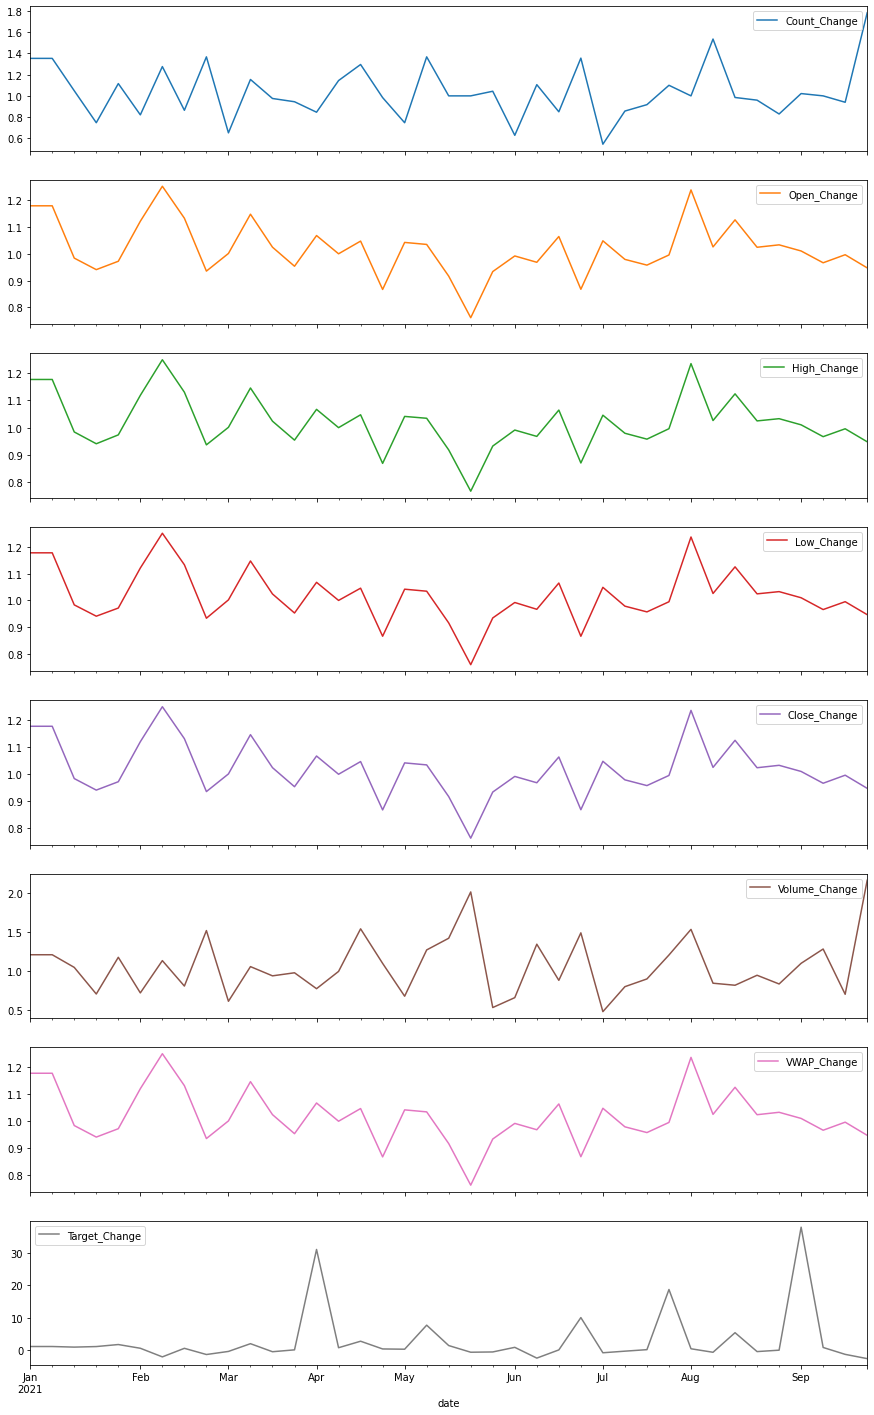

In [53]:
# plot the weekly change =====> thisWeekReading / previousWeekReading
# this enables us to trace the trend of the ratio of these features. 
# wherever the value is greater than one, this means that this feature 
# has reported an increment from the previous week 
df_week[df_week['Asset_ID'] == 1][[f'{col}_Change' for col in ['Count', 'Open', 'High', 'Low', 'Close', 
                                                               'Volume', 'VWAP', 'Target']]].plot(subplots=True, figsize=(15, 25))
plt.show()

In [54]:
# in many cases percent change is informative
cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']
for col in cols:
    df_week[f'{col}_pct_change'] = df_week[col].pct_change()*100
    
df_week = df_week.fillna(method='bfill')

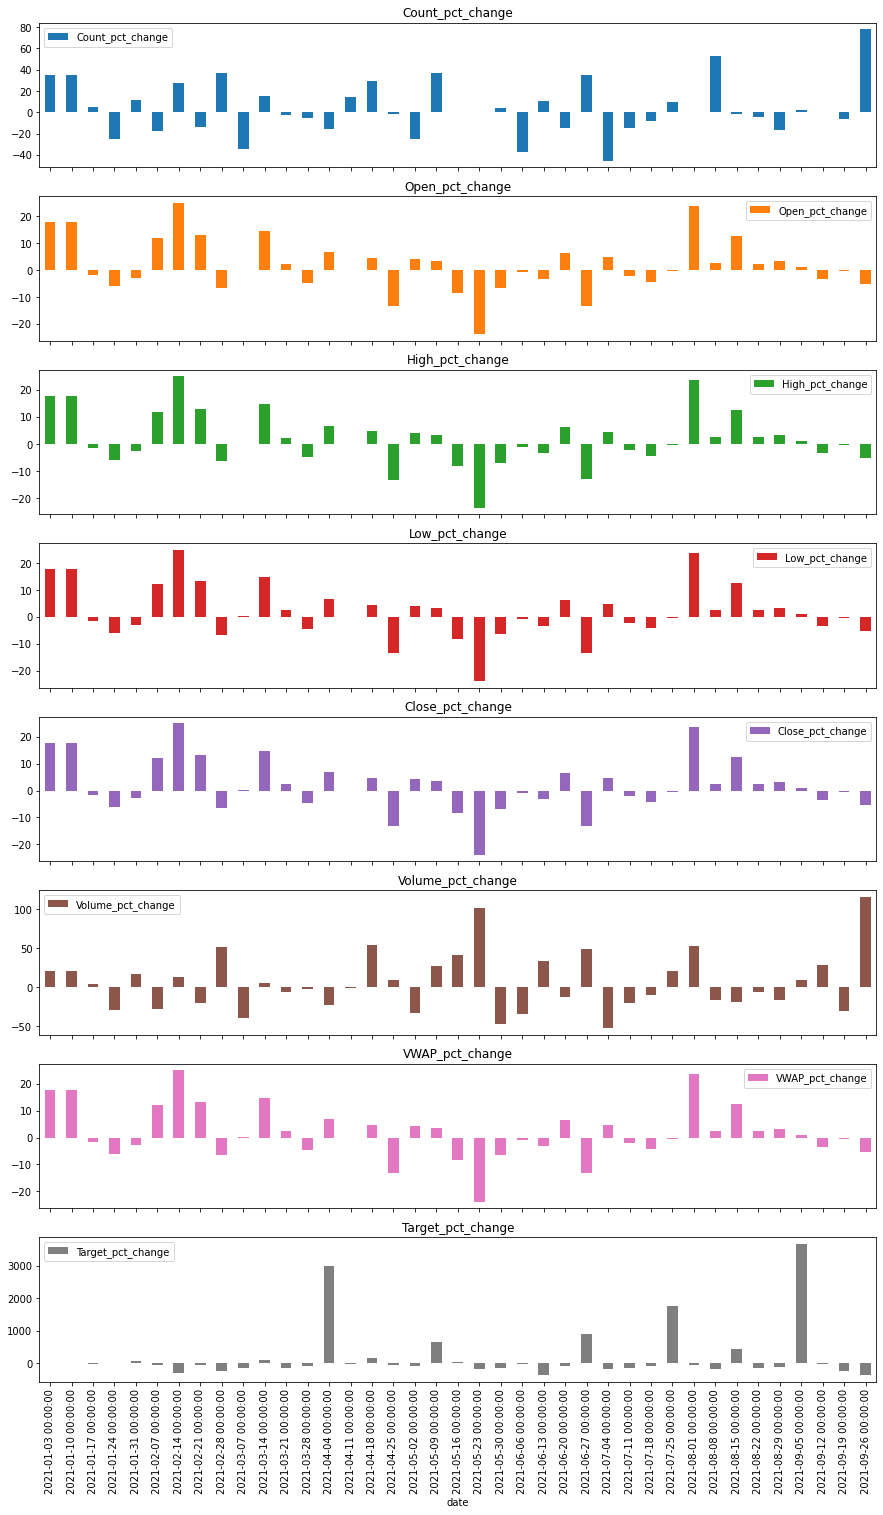

In [55]:
# plot the weekly change =====> thisWeekReading / previousWeekReading
df_week[df_week['Asset_ID'] == 1][[f'{col}_pct_change' for col in ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']]]\
                                                                    .plot(kind='bar', subplots=True, figsize=(15, 25))
plt.show()

In [56]:
# here for each column we plot the original values versus the expanding mean (cumulative mean) versus the expanding std

cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']
for col in cols:
    df_week[f'{col}_expanding_mean'] = df_week[col].expanding().mean()
    df_week[f'{col}_expanding_std'] = df_week[col].expanding().std()

df_week = df_week.fillna(method='bfill')

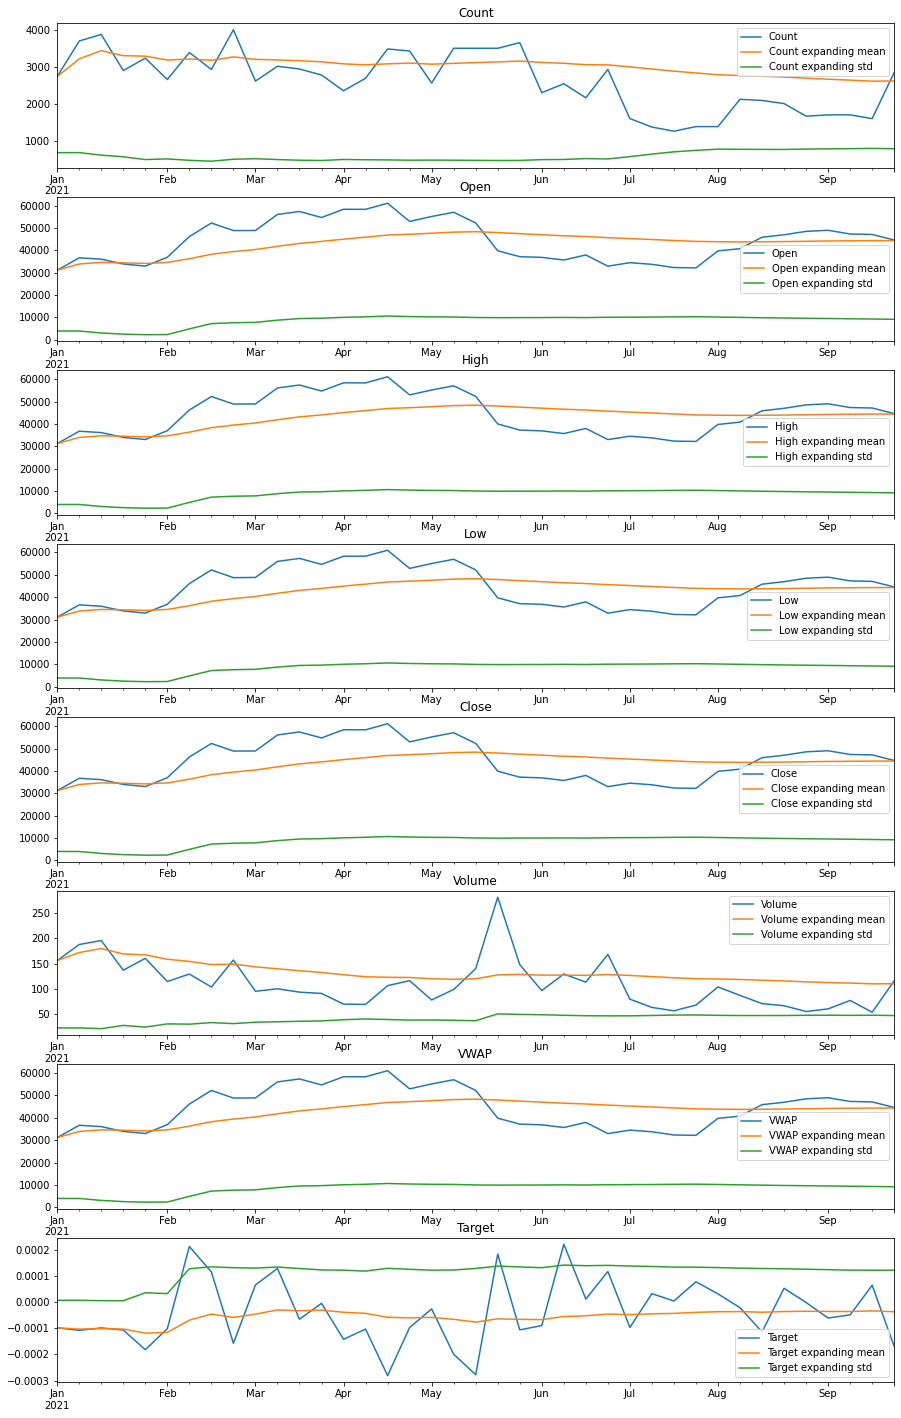

In [57]:
# here for each column we plot the original values versus the expanding mean (cumulative mean) versus the expanding std

fig, axes = plt.subplots(8, 1, figsize=(15, 25), sharex=False)
for i, (name, ax) in enumerate(zip(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target'], axes)):
    plt.subplot(8, 1, i+1)
    ax = df_week[f'{name}'].plot(label=name)
    ax = df_week[f'{name}_expanding_mean'].plot(label=f'{name} expanding mean')
    ax = df_week[f'{name}_expanding_std'].plot(label=f'{name} expanding std')
    ax.set_ylabel(name)
    ax.legend()
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

plt.show()

These plots assures the high volatility of the data, where data statistics such as mean and standard deviation are varying over time.

In [58]:
df_hour = df[df['Asset_ID'] == 1].resample("H").mean().astype('float64')
df_hour = df_hour.fillna(method='pad')

df_hour['day_'] = df_hour['day_'].astype(int)
df_hour['hr_'] = df_hour['hr_'].astype(int)

In [59]:
hour_day_df = pd.pivot_table(df_hour, 
                             values="Close",
                             index=['hr_'],
                             columns=['day_'],
                             fill_value=0,
                             margins=True)

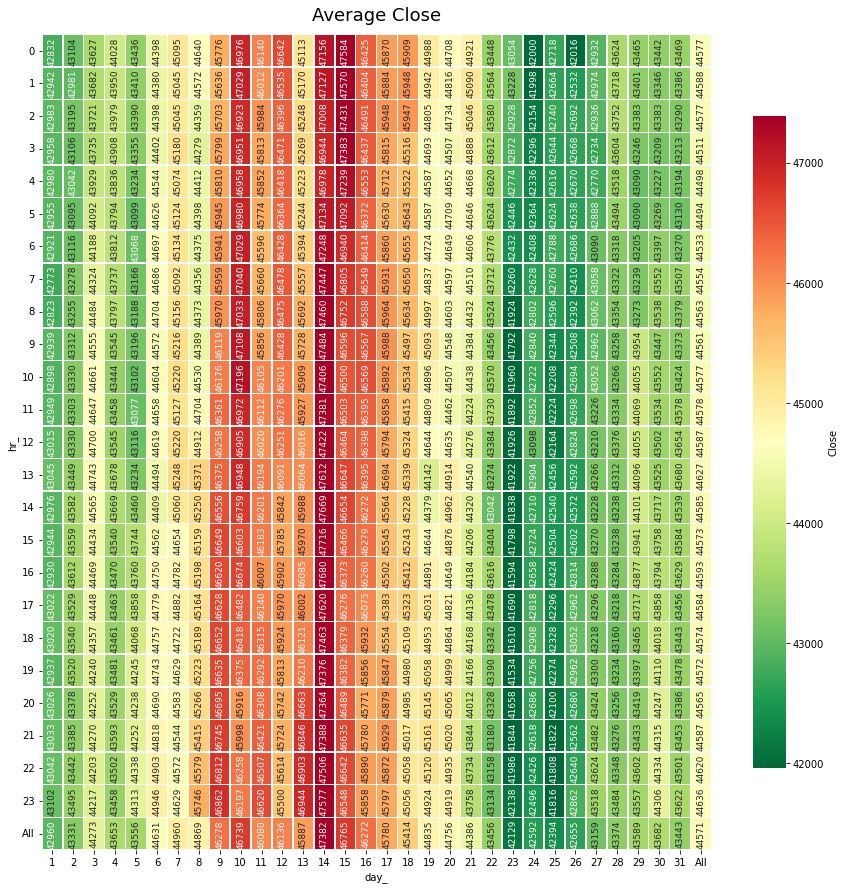

In [60]:
# this heat map enables us to keep track of hours of all days over all months and see which hours of day had the 
# the highest mean close value and which ones had the smallest values 
plt.figure(figsize=(15, 15))
ax = sns.heatmap(hour_day_df, cmap='RdYlGn_r', robust=True, fmt='.0f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Close'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Close', fontdict={'fontsize':18},    pad=14)
plt.show()

We can see that on average the days with the high opening values take place during the half of the month, especially between the 9th and 17th day

# **Lin Regr**

In [2]:
#import libraries
import time
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor


In [3]:
#read data
data_folder = "../content/"
crypto_df = pd.read_csv(data_folder + 'train.csv')
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


## Data features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:

**timestamp:** All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.

**Asset_ID:** The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.

**Count:** Total number of trades in the time interval (last minute).

**Open:** Opening price of the time interval (in USD).

**High:** Highest price reached during time interval (in USD).

**Low:** Lowest price reached during time interval (in USD).

**Close:** Closing price of the time interval (in USD).

**Volume:** Quantity of asset bought or sold, displayed in base currency USD.

**VWAP:** The average price of the asset over the time interval, weighted by 
. VWAP is an aggregated form of trade data.

**Target:** Residual log-returns for the asset over a 15 minute horizon.


The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.


We also view the asset information, including the list of all assets, the Asset_ID to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

In [4]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Visualize data: Candlestick Bar
The trading data format is an aggregated form of market data including for Open, High, Low and Close. We can visualize this data through the commonly used candlestick bar chart, which allows traders to perform technical analysis on intraday values.

The bar's body length represents the price range between the open and close of that day's trading. When the bar is red, it means the close was lower than the open, and green otherwise. These are also referred to as bullish and bearish candlesticks. The wicks above and below the bars show the high and low prices of that interval's trading.

The bottom part of the plot shows a rangeslider, which you can use to zoom in the plot.

In [5]:
# Asset_ID = 1 for Bitcoin, for example
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") 

# select recent data rows
btc_mini = btc.iloc[-200:] 

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, 
                                     open=btc_mini['Open'], 
                                     high=btc_mini['High'], 
                                     low=btc_mini['Low'], 
                                     close=btc_mini['Close'])])
fig.show()

In [6]:
#Exploratory Data Analysis (EDA) and check for the missing data
# Asset_ID = 6 for Ethereum, as example
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp") 
eth.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      340
dtype: int64

In [7]:
#As we can see, there are 340 missed "Target" values.
#Let's check the time range for Bitcoin and Ethereum data, using the coversion from timestamp to datetime.
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')

print('BTC data goes from ', beg_btc, 'to ', end_btc)
print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00
Ethereum data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


In [8]:
#check for timegaps
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

In [9]:
#To work with most time series models, we should preprocess our data into a format without time gaps. 
#To fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value.

eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

In [10]:
#check that are no time gaps now
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

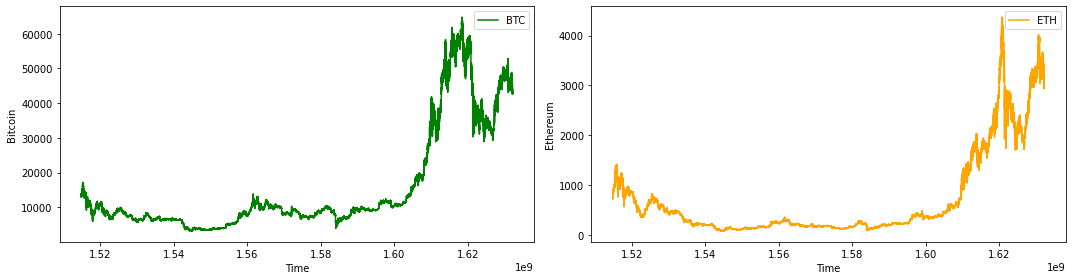

In [11]:
#Data visualisation
# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))

ax = f.add_subplot(121)
plt.plot(btc['Close'], color = 'green', label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['Close'], color='orange', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

In [12]:
#check if they correlate in recent time
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals 
btc_mini_2021 = btc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

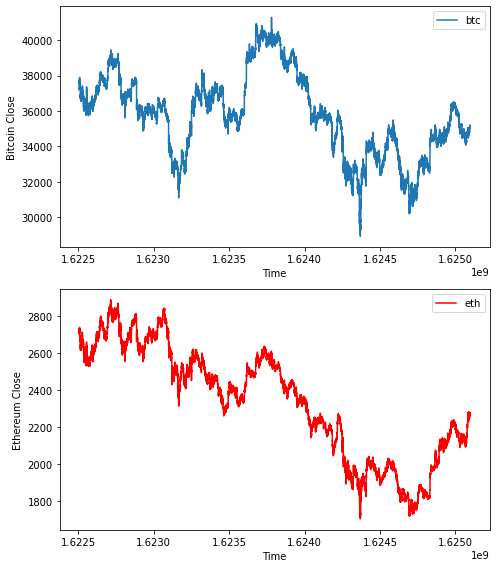

In [13]:
# plot time series for both chosen assets
f = plt.figure(figsize=(7,8))

ax = f.add_subplot(211)
plt.plot(btc_mini_2021['Close'], label='btc')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

ax2 = f.add_subplot(212)
ax2.plot(eth_mini_2021['Close'], color='red', label='eth')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')

plt.tight_layout()
plt.show()

## Log returns
In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

In [14]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

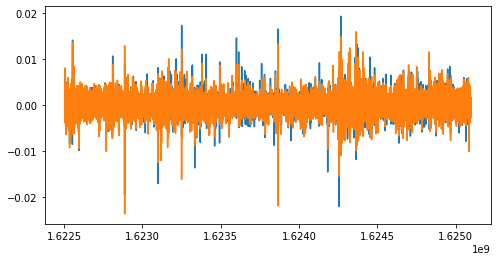

In [15]:
lret_btc = log_return(btc_mini_2021.Close)[1:]
lret_eth = log_return(eth_mini_2021.Close)[1:]
lret_btc.rename('lret_btc', inplace=True)
lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(8,4))
plt.plot(lret_btc);
plt.plot(lret_eth);
plt.show()

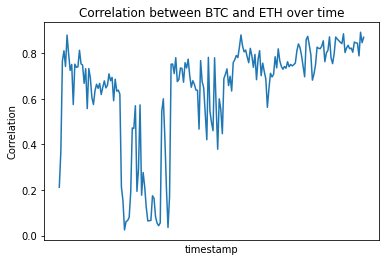

In [16]:
#Correlation between assets
#We can check how the correlation between Bitcoin and Ethereum change over time for the 2021 period we selected.
# join two asset in single DataFrame

lret_btc_long = log_return(btc.Close)[1:]
lret_eth_long = log_return(eth.Close)[1:]
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

corr_time.plot()
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between BTC and ETH over time")
plt.show()

Note the high but variable correlation between the assets. Here we can see that there is some changing dynamics over time, and this would be critical for this time series challenge, that is, how to perform forecasts in a highly non-stationary environment.

A stationary behaviour of a system or a process is characterized by non-changing statistical properties over time such as the mean, variance and autocorrelation. On the other hand, a non-stationary behaviour is characterized by a continuous change of statistical properties over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

We can also check the correlation between all assets visualizing the correlation matrix. Note how some assets have much higher pairwise correlation than others.

In [17]:
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
    asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
    asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
    lret = log_return(asset.Close.fillna(0))[1:]
    all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

In [18]:
asset_details.Asset_ID

0      2
1      0
2      1
3      5
4      7
5      6
6      9
7     11
8     13
9     12
10     3
11     8
12    10
13     4
Name: Asset_ID, dtype: int64

In [19]:
asset_details.Asset_Name

0         Bitcoin Cash
1         Binance Coin
2              Bitcoin
3               EOS.IO
4     Ethereum Classic
5             Ethereum
6             Litecoin
7               Monero
8                 TRON
9              Stellar
10             Cardano
11                IOTA
12               Maker
13            Dogecoin
Name: Asset_Name, dtype: object

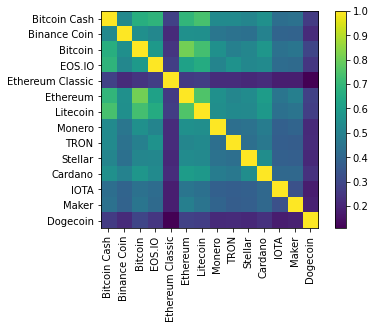

In [20]:
plt.imshow(all_assets_2021.corr());
plt.yticks(range(14), asset_details.Asset_Name.values);
plt.xticks(range(14), asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar()
plt.show()

## Predictions

In [21]:
#Feature engineering
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), 
                   log_return(btc.VWAP,periods=1).abs(), 
                   upper_shadow(btc), 
                   lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), 
                   log_return(eth.VWAP,periods=1).abs(), 
                   upper_shadow(eth), 
                   lower_shadow(eth)], axis=1)
y_eth = eth.Target

In [22]:
#Preparing the data for building predictive models
#As we will train linear regression parameters, we need to separate training and test sets. To do so, we will compute X and y and split this data into train and test splits.
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [23]:
#Normalize data
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

In [24]:
#Linear Regression
# implement basic ML baseline (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

In [25]:
# we concatenate X and y for both assets
X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
mlr.fit(X_both_train,y_both_train)
y_pred_lr_both = mlr.predict(X_both_test)

In [26]:
#Evaluate results
print('Test score for LR baseline: BTC', 
      f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}", ', ETH', 
      f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")

print('Test score for multiple output LR baseline: BTC', 
      f"{np.corrcoef(y_pred_lr_both[:,0], y_btc_test)[0,1]:.2f}",', ETH', 
      f"{np.corrcoef(y_pred_lr_both[:,1], y_eth_test)[0,1]:.2f}")

Test score for LR baseline: BTC -0.01 , ETH 0.02
Test score for multiple output LR baseline: BTC 0.01 , ETH 0.05
